In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature Selection with Lasso, Ridge, ElasticNet in Python and "scikit-learn"

Today we'll use the "scikit-learn" (aka `sklearn`) implementation of these models. "scikit-learn" is a machine learning-focused library that has a ton of helper functions for data scientists to quickly and efficiently try a lot of different models.

## Prerequisites: Statquest Playlist

Since this notebook is mainly to show you how to implement these models in python, you should watch this Statquest playlist to get the intuition behind these models:

* [Regularization Part 1: Ridge](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Regularization Part 2: Lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [Regularization Part 3: ElasticNet](https://www.youtube.com/watch?v=1dKRdX9bfIo)
* [Machine Learning: Cross Validation](https://www.youtube.com/watch?v=fSytzGwwBVw)
* [Machine Learning Fundamentals: Bias-Variance Tradeoff](https://www.youtube.com/watch?v=EuBBz3bI-aA)
* [Support Vector Machines](https://www.youtube.com/watch?v=efR1C6CvhmE)

## The `sklearn` workflow

The most basic `sklearn` model workflow goes something like this:

| Step | Action | Example |
| --- | --- | --- |
| 0 | Import the model from `sklearn` | `from sklearn.linear_model import LinearRegression` |
| 1 | Instantiate the model class | `model = LinearRegression()` |
| 2 | Fit the model | `model.fit(X, y)` |
| 3 | Use the fitted model to make a prediction | `model.predict(X)` |

This standard interface is what makes `sklearn` so powerful - with `.fit()` and `.predict()` and a huge variety of models in the library, you can use this common language to try all sorts of machine learning models. 

And that's just the start, from this basic 3-step pipeline you can add all kinds of additional steps to this worfklow that make experimentation very convenient for the user.

## Example: Linear Regression in `sklearn`

Before we cover Lasso, Ridge, and ElasticNet in `sklearn` it might be helpful to demonstrate some basic functionality with doing a linear regression. 

**Reference**: [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [2]:
# Import the model
from sklearn.linear_model import LinearRegression

Next we'll load in our data. We'll be using `seaborn`, a visualization library that has some 'toy' datasets to play with and we'll also use it briefly for some specialized plots. 

The `mpg` dataset is a famous dataset that has some car engine attributes like engine displacement (engine size) and others that can be used to estimate the car's fuel efficiency, measured in miles per gallon or `mpg`.

We can load it in using the `sns.load_dataset()` function:

In [3]:
# load mpg example dataset
mpg = sns.load_dataset("mpg")
# we'll filter on just a few columns and drop na/empty values 
mpg = mpg[['mpg', 'displacement', 'horsepower', 'weight']].dropna() 
X = mpg[['displacement', 'horsepower', 'weight']]
y = mpg['mpg']

And one helpful plot for you would be the `sns.pairplot` function that will plot scatterplots for each of the variables against each other and also display the distribution for each variable as a histogram:

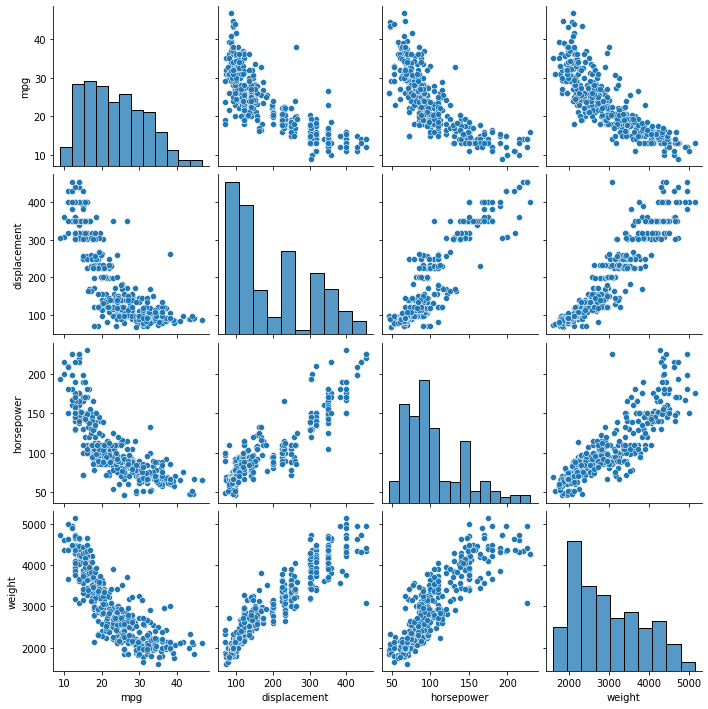

In [4]:
# Convenience method to plot pairs of variables together all in one go!
sns.pairplot(mpg)

Next, we'll follow the `sklearn` workflow.

Let's model the relationship between average MPG and engine displacement and get a quick $R^2$ value:

In [5]:
# Filter on just the 'displacement' variable in the X dataframe
x = X[["displacement"]]

model = LinearRegression()
model.fit(x, y)

# model.score() returns the model R^2 in this case
R2 = model.score(x, y)
print("Model R^2: ", R2)

Model R^2:  0.6482294003193044


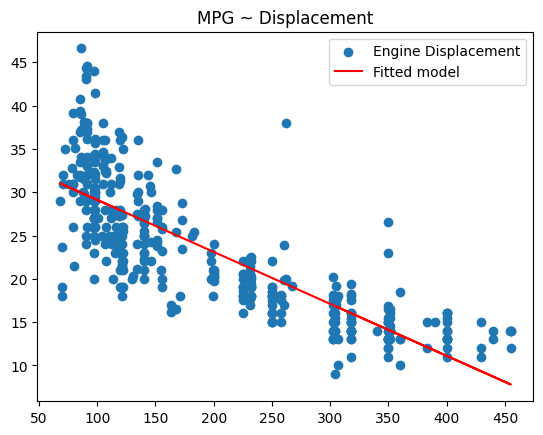

In [6]:
# Show the fitted values
yhat = model.predict(x)

plt.scatter(x, y, label="Engine Displacement")
plt.plot(x, model.predict(x), label="Fitted model", c="r")
plt.title("MPG ~ Displacement")
plt.legend()
plt.show()

With Linear Regression and similar models, we can extract the fitted coefficients and the intercept with two commands:

1. `model.coef_` will return the coefficients
2. `model.intercept_` will return the intercept

In [7]:
print("model coefficient(s):", model.coef_)
print("model intercept:", model.intercept_)

model coefficient(s): [-0.06005143]
model intercept: 35.12063593840391


Notice that this has fewer "batteries included" than statsmodels but it gets the job done. So if you wanted other summary statistics like p-values you will need to do them *manually* in `sklearn`. 

But all that aside, in math terms, we've just fit the model:

$$
\hat{Y} = -0.06x + 35.12
$$

where $x$ is the engine displacement and $\hat{Y}$ is the estimated average value of mpg. In other words, for every unit increase in engine displacement, average mpg is expected to decrease by -0.06. 

# Feature Selection with Lasso/Ridge/ElasticNet

In [8]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# For this exercise we'll split the data into training and test sets
from sklearn.model_selection import train_test_split
# And we'll need to scale the data
from sklearn.preprocessing import StandardScaler

`sklearn` Reference:

* [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)
* [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
* [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)

## Scaling your data

With regularization models **you must scale your data**!

Since we're dealing with penalties, we need to standardize the scale of data so the regularization penalty doesn't over-penalize numbers that are orders of magnitude higher than others. 

The `StandardScaler()` class in `sklearn` helps us with this, and using it is simple:

1. Instantiate the scaler class with `StandardScaler()`
2. `fit` the scaler with the `.fit()` method on the data
3. Finally, `transform` the data with `.transform()` 
    1. Alternatively, you can combine both the `.fit` and `.transform` steps with a single `.fit_transform()` call
    
And this particular scaler simply takes the X data and standardizes them into Z-scores by subtracting the mean and dividing over the standard deviation, i.e.:

$$
\text{scaled horsepower} = \frac{\text{horsepower} - \text{average horsepower}}{\text{horsepower standard deviation}}
$$

In [9]:
# Here's the data again for clarity
X = mpg[['displacement', 'horsepower', 'weight']]
y = mpg['mpg']

# Instantiate the Scaler class
scaler = StandardScaler()
# Fit and then transform the X-data
scaled_X = scaler.fit_transform(X)
# The transformed data is now an array, we want to convert it back
# to a dataframe for easier parsing (optional)
scaled_X = pd.DataFrame(scaled_X, columns=['displacement', 'horsepower', 'weight'])

**note**: This transformation is a little messy because I'm scaling only the X values (i.e. the engine displacement, horsepower, and weight) and leaving the y unscaled to help a little with the interpretation piece. This code is normally much simpler when you are scaling the y values as well.

In [10]:
# We'll take our scaled X values and combine it with the unscaled y
df = scaled_X.copy()
df['mpg'] = y
df = df.dropna()

### `train_test_split()`

The next step we will perform is to divide the data into two parts: a training set and a test set.

* Here's a Statquest video on why we do this: [Machine Learning Fundamentals: Bias and Variance](https://www.youtube.com/watch?v=EuBBz3bI-aA)

In [11]:
# split the new dataframe into train/test
mpg_train, mpg_test = train_test_split(df, test_size=0.20, random_state=42)

X_train = mpg_train[['displacement', 'horsepower', 'weight']]
X_test = mpg_test[['displacement', 'horsepower', 'weight']]
y_train = mpg_train['mpg']
y_test = mpg_test['mpg']

## Lasso Regression

Statquest video: [Regularization Part 2: Lasso (L1) Regression](https://www.youtube.com/watch?v=NGf0voTMlcs)

First model we'll demonstrate is a single call of Lasso and manually set the value of the alpha parameter.

[Lasso](Regularization Part 2: Lasso (L1) Regression) penalizes the less important features by reducing their coefficients (possibly to zero), unlike [Ridge Regression](https://www.youtube.com/watch?v=Q81RR3yKn30) which merely shrinks the coefficients for the less important features but cannot set them to zero entirely.

In [12]:
model = Lasso(alpha=0.01, random_state=42)
model.fit(X_train, y_train)
R_2 = model.score(X_test, y_test)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

R^2 Value:  0.27


So our simple Lasso model fit on the training data resulted in a $R^2$ of 0.27 on the test data. That is not so good! But the important piece is that we should look at the model coefficients:

In [13]:
print("intercept: ", model.intercept_)
pd.DataFrame({"feature": model.feature_names_in_,
             "coefficients":model.coef_})

intercept:  23.348832405776655


,feature,coefficients
0,displacement,-2.317209
1,horsepower,-1.852412
2,weight,-0.818235


### How do I interpret this?

So, in math terms, here's what the above model is saying:

$$
\text{expected mpg} = -2.32(\text{displacement}) - 1.85(\text{horsepower}) - 0.82(\text{weight}) + 23.35
$$

So for every unit increase in `displacement` we expect to see a **decrease** in `mpg` by 2.32 miles per gallon. That's a lot! But note here that we *scaled* the displacement, horsepower, and weight numbers. If we want to convert these coefficients back to the original scale, we'll need to do a little math. I'll skip it for now but just know that it's possible in this situation. 

But this is a post on **feature importance**, so how would you do this with Lasso, Ridge, or ElasticNet?

### Feature Importance with Lasso

So we notice that with the `alpha` parameter at a low value of 0.01, Lasso didn't send any of these variables to zero. If we were to increase the `alpha` parameter, we would see that some of these coefficients would go to zero. 

So one way of interpreting **feature importance** with Lasso or Ridge is to try different values of `alpha` and see what happens to the coefficients.

The code below shows an example:

In [14]:
coefs = []
alphas = np.arange(0.01,10, 0.01)
for a in alphas:
    model = Lasso(alpha=a, random_state=42)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)

Then we'll do a plot of the coeffient values vs `alpha`. 

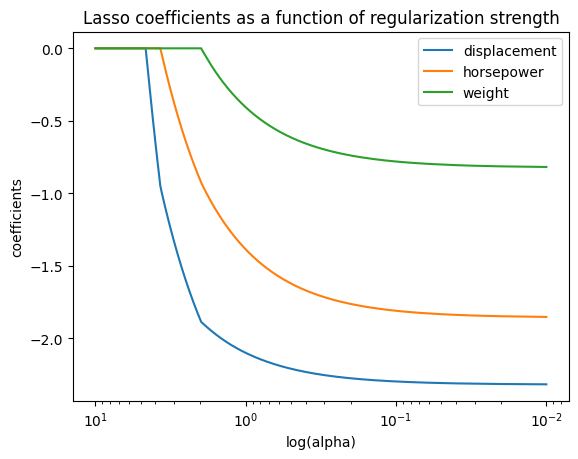

In [15]:
ax = plt.gca()

ax.plot(alphas, coefs, label=['displacement', 'horsepower', 'weight'])
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso coefficients as a function of regularization strength")
plt.axis("tight")
plt.legend()
plt.show()

### How do you read this?

So you might notice a few funky things about this plot. I reversed the x-axis so that alpha decreases from left to right, so regularization strength is *decreasing* from left to right. And the coefficients are *negative* before going to zero with higher values of alpha. A little confusing but it's a convention.

But notice how we have an order in which the lines go to zero. In the above example, `weight` is the first value to go to zero as alpha increases, followed by `horsepower`, and then `displacement`. This gives you a *relative* idea of the feature importance which might be helpful in your understanding of the problem. 

For another example with Ridge Regression, [check this out](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

**Note:** Another term for this kind of plot is a 'path' plot, and `sklearn` has some helper functions, [see example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py)

### How do you find the best value of alpha for prediction accuracy?

Now, another twist on the problem is if your goal isn't learning feature importance and your goal is to do prediction and let the models do the shrinkage for you, then you can repeatedly try a lot of different values of `alpha` and find the value that gives you the least error on the test set. In the below example we'll use root mean squared error (RMSE) as our error metric that we're optimizing for:

In [16]:
yhat = model.predict(X_test)
RMSE = (np.mean((yhat - y_test)**2))**0.5
print(RMSE)

7.019453139121642


Then we iterate over several values of alpha:

In [17]:
errors = []
alphas = np.arange(0.01,10, 0.01)
for a in alphas:
    model = Lasso(alpha=a, random_state=42)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    RMSE = (np.mean((yhat - y_test)**2))**0.5
    errors.append(RMSE)

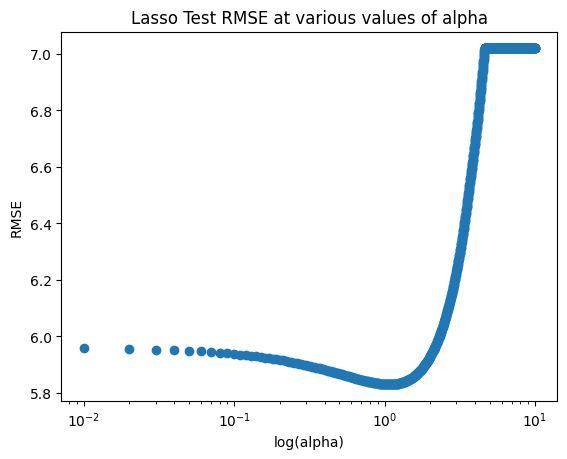

In [18]:
ax = plt.gca()

plt.scatter(alphas, errors)
ax.set_xscale("log")
plt.xlabel("log(alpha)")
plt.ylabel("RMSE")
plt.title("Lasso Test RMSE at various values of alpha")
plt.show()

In [19]:
best_alpha = alphas[np.argmin(errors)]
print("best_alpha = ", best_alpha)

best_alpha =  1.07


We can then plug that best alpha back in to our model:

In [20]:
model = Lasso(alpha=best_alpha, random_state=42)
model.fit(X_train, y_train)
R_2 = model.score(X_test, y_test)

# print the score rounded to two digits
print("Test R^2 Value: ", np.round(R_2,2))

Test R^2 Value:  0.3


So, we get a minor improvement!

In [21]:
pd.DataFrame({"feature": model.feature_names_in_,
             "coefficients":model.coef_})

,feature,coefficients
0,displacement,-2.084907
1,horsepower,-1.353816
2,weight,-0.377263


And notice here that since we were optimizing for RMSE on the test set, we found a value of `alpha` that shrunk the coefficients but didn't set any of them to zero. If we had increased `alpha` more we would eventually see `weight` fall off.

#### Visualizing the model fit

So since we are dealing with multivariable regression we can't make a 4-D plot to show the 4-D hyperplane that this model fit. But we can kind of get a sense by plotting just a single predictor variable (i.e. 'horsepower') against the value of `mpg` to get some intuition:

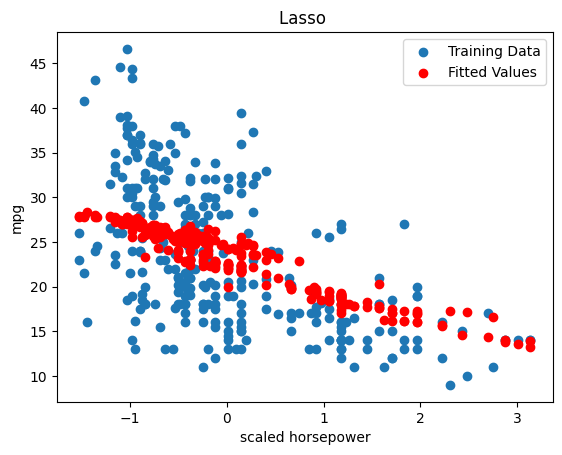

In [22]:
y_fitted = model.predict(X_train)
plt.scatter(X_train[["horsepower"]], y_train, label="Training Data")
plt.scatter(X_train[["horsepower"]], y_fitted, label="Fitted Values", c="r")
plt.title("Lasso ")
plt.xlabel("scaled horsepower")
plt.ylabel("mpg")
plt.legend()
plt.show()

But, can we do better?

## How do you find `alpha`?

In practice you could iteratively try many many different kinds of alpha until you arrived at the best answer - and you could do this manually (as we just did above) but `sklearn` has helper functions that already do this for you. 

Here we'll use 5-fold cross validation to find the ideal value of alpha from the training set, and then use that fitted model on the test set.

`sklearn` has `LassoCV`, `RidgeCV`, and `ElasticNetCV` implementations for our convenience. Here we'll repeat the analysis from above as a demo with these three. 

In [23]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

0.26601042348436355


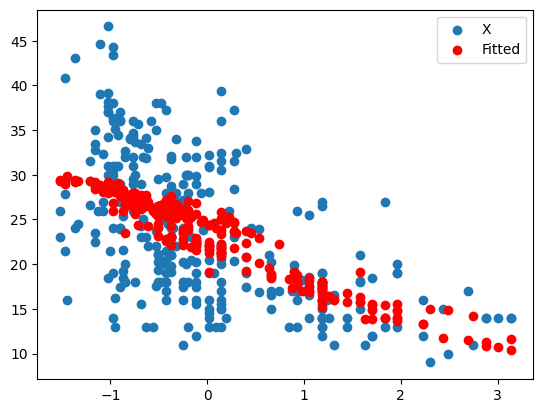

In [24]:
model = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
print(model.score(X_test,y_test))

y_fitted = model.predict(X_train)
plt.scatter(X_train[["horsepower"]], y_train, label="X")
plt.scatter(X_train[["horsepower"]], y_fitted, label="Fitted", c="r")
plt.legend()
plt.show()

In [25]:
model.alpha_

0.004619906312005148

In [26]:
pd.DataFrame({"feature": model.feature_names_in_,
             "coefficients":model.coef_})

,feature,coefficients
0,displacement,-2.318341
1,horsepower,-1.854957
2,weight,-0.820504


0.2709055015774047


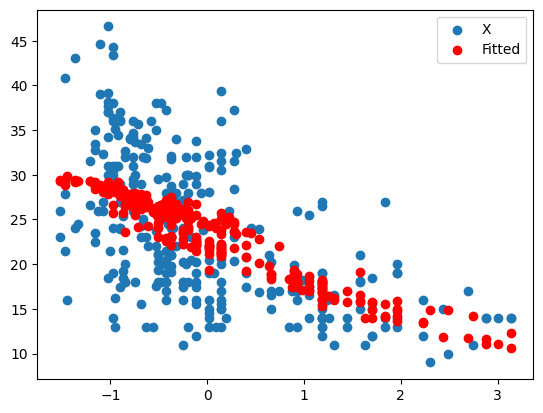

In [27]:
model = RidgeCV(cv=5).fit(X_train, y_train)
print(model.score(X_test, y_test))

y_fitted = model.predict(X_train)
plt.scatter(X_train[["horsepower"]], y_train, label="X")
plt.scatter(X_train[["horsepower"]], y_fitted, label="Fitted", c="r")
plt.legend()
plt.show()

In [28]:
model.alpha_

10.0

In [29]:
pd.DataFrame({"feature": model.feature_names_in_,
             "coefficients":model.coef_})

,feature,coefficients
0,displacement,-2.074038
1,horsepower,-1.827595
2,weight,-1.040466


### ElasticNet

Finally, ElasticNet combines both Lasso and Ridge penalties so you can get the best of both worlds:

0.27858321488177085


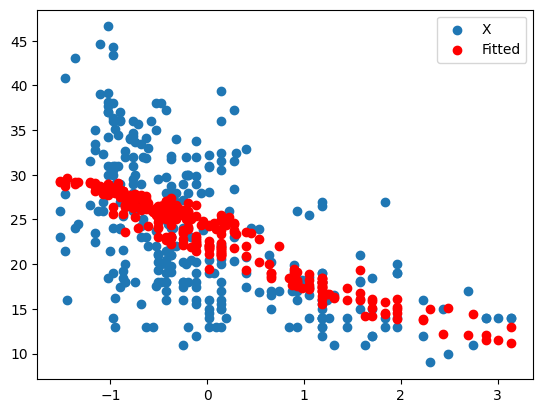

In [30]:
model = ElasticNetCV(cv=5).fit(X_train, y_train)

print(model.score(X_test, y_test))
y_fitted = model.predict(X_train)
plt.scatter(X_train[["horsepower"]], y_train, label="X")
plt.scatter(X_train[["horsepower"]], y_fitted, label="Fitted", c="r")
plt.legend()
plt.show()

We can get the `l1_ratio_` back out from here too. The L1 ratio in this case describes the relative weight it gives the Lasso vs Ridge parameters.

In [31]:
model.l1_ratio_

0.5

In [32]:
model.alpha_

0.14043693611641683

In [33]:
pd.DataFrame({"feature": model.feature_names_in_,
             "coefficients":model.coef_})

,feature,coefficients
0,displacement,-1.909155
1,horsepower,-1.753583
2,weight,-1.137835


# Interim Summary

So hopefully this helps you understand how to implement Lasso, Ridge, and ElasticNet in python using `sklearn`. These models would be my go-to to try to estimate feature importance and feature selection because they retain much of the interpretability of Linear Regression. 

But, what about an even more flexible model that could fit **non-linear** relationships in your data? At this point we must pursue more flexible but less interpretable models like popular tree-based models (Random Forest, XGBoost, etc) or less-popular approaches like Support Vector Regression (SVR).

## What is Support Vector Regression? 

In Support Vector Regression (SVR), the separating hyperplane from Support Vector Machines (SVM) is instead used as the regression line and the decision boundary is used to determine best fit. The benefit of using SVR is that it can capture non-linearity and is robust to outliers and can offer a very flexible fit (with all of those downsides). So in a prediction/forecasting setting this might be very accurate, but you don't get interpretability or inference.

## Example: Support Vector Regression in `sklearn`

For this first example, we'll re-do our initial Linear Regression example of modeling `mpg` with `displacement` and plot the fitted data:

In [34]:
from sklearn.svm import SVR

R^2 Value:  0.68


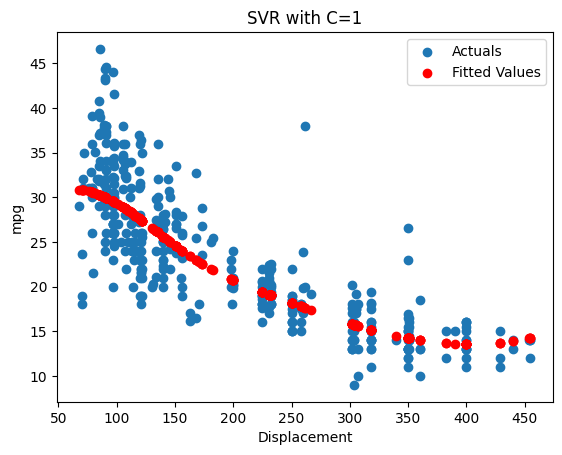

In [35]:
x = X[["displacement"]]

model = SVR(C=1.0, epsilon=0.2, kernel='rbf')
model.fit(x, y)
R_2 = model.score(x, y)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

y_fitted = model.predict(x)
plt.scatter(x, y, label="Actuals")
plt.scatter(x, y_fitted, label="Fitted Values", c="r")
plt.xlabel("Displacement")
plt.ylabel("mpg")
plt.title("SVR with C=1")
plt.legend()
plt.show()

Note that we now have a curved fit in this example, even with the default $C$ value of 1.0. In SVR, $C$ represents the *inverse* of the regularization parameter that we had seen before. So, the lower the value of $C$, the higher the strength of regularization. Another way to think about it is with low $C$ you get a smoother curve and with high $C$ you can get a more 'wiggly' curve.

R^2 Value:  0.69


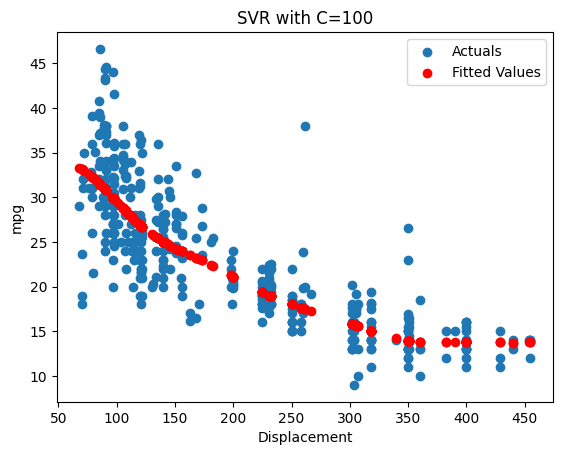

In [36]:
model = SVR(C=100.0, epsilon=0.2, kernel='rbf')
model.fit(x, y)
R_2 = model.score(x, y)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

y_fitted = model.predict(x)
plt.scatter(x, y, label="Actuals")
plt.scatter(x, y_fitted, label="Fitted Values", c="r")
plt.xlabel("Displacement")
plt.ylabel("mpg")
plt.title("SVR with C=100")
plt.legend()
plt.show()

So you might be thinking "that's a great $R^2$ value!", but we had just fit the model on the entire dataset. In practice we'll need to use our training data to fit the model and then evaluate the model performance on the 'unseen' test data:

R^2 Value:  0.11


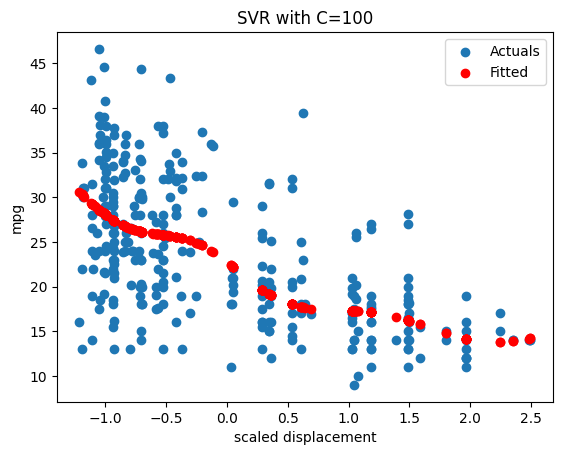

In [37]:
x_train = X_train[["displacement"]]
x_test = X_test[["displacement"]]

model = SVR(C=100.0, epsilon=0.2, kernel='rbf')
model.fit(x_train, y_train)
R_2 = model.score(x_test, y_test)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

y_fitted = model.predict(x_train)
plt.scatter(x_train, y_train, label="Actuals")
plt.scatter(x_train, y_fitted, label="Fitted", c="r")
plt.title("SVR with C=100")
plt.xlabel("scaled displacement")
plt.ylabel("mpg")
plt.legend()
plt.show()

And we see that the fit looks pretty good, but what's happening with the test set to get such a low $R^2$?

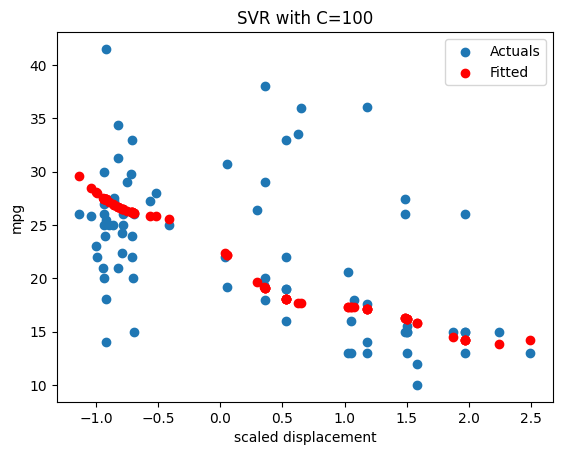

In [38]:
# print the score rounded to two digits
y_pred = model.predict(x_test)

plt.scatter(x_test, y_test, label="Actuals")
plt.scatter(x_test, y_pred, label="Fitted", c="r")
plt.title("SVR with C=100")
plt.xlabel("scaled displacement")
plt.ylabel("mpg")
plt.legend()
plt.show()

And here we may have a case of overfitting where we set $C$ too high. 

Instead, we could try a less flexible model and then we would hope to improve the model performance on the test set. Next, we'll set the C back down to 1 and use a `linear` kernel instead of `rbf`:

R^2 Value:  0.2


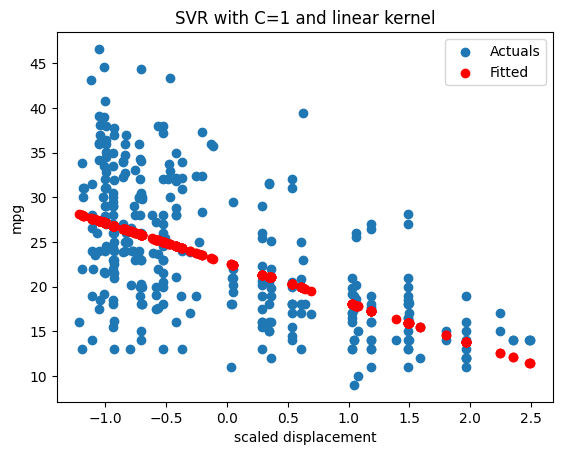

In [39]:
x_train = X_train[["displacement"]]
x_test = X_test[["displacement"]]

model = SVR(C=1, epsilon=0.2, kernel='linear')
model.fit(x_train, y_train)
R_2 = model.score(x_test, y_test)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

y_fitted = model.predict(x_train)
plt.scatter(x_train, y_train, label="Actuals")
plt.scatter(x_train, y_fitted, label="Fitted", c="r")
plt.title("SVR with C=1 and linear kernel")
plt.xlabel("scaled displacement")
plt.ylabel("mpg")
plt.legend()
plt.show()

And we notice that this starts looking a little more like linear regression in that it did a linear fit. You can even get the coefficients and intercept back out:

In [40]:
print("model coefficient(s):", model.coef_)
print("model intercept:", model.intercept_)

model coefficient(s): [[-4.49507286]]
model intercept: [22.64249525]


### SVR with all predictors

Now we set the regularization strength back down to 1.0 and fit on all of the predictors:

R^2 Value:  0.21


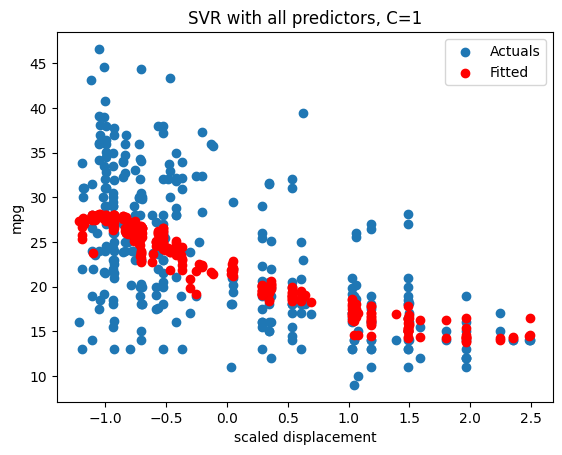

In [41]:
model = SVR(C=1.0, epsilon=0.2, kernel='rbf')
model.fit(X_train, y_train)
R_2 = model.score(X_test, y_test)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

y_fitted = model.predict(X_train)
plt.scatter(x_train, y_train, label="Actuals")
plt.scatter(x_train, y_fitted, label="Fitted", c="r")
plt.xlabel("scaled displacement")
plt.ylabel("mpg")
plt.legend()
plt.title("SVR with all predictors, C=1")
plt.show()

With SVR we can't get regression coefficients out unless we use a `linear` kernel. The documentation suggests that we use `LinearSVR` instead of calling `SVR(kernel='linear')` because it offers more flexibility and it's more performant:

[LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

In [42]:
from sklearn.svm import LinearSVR

R^2 Value:  0.2


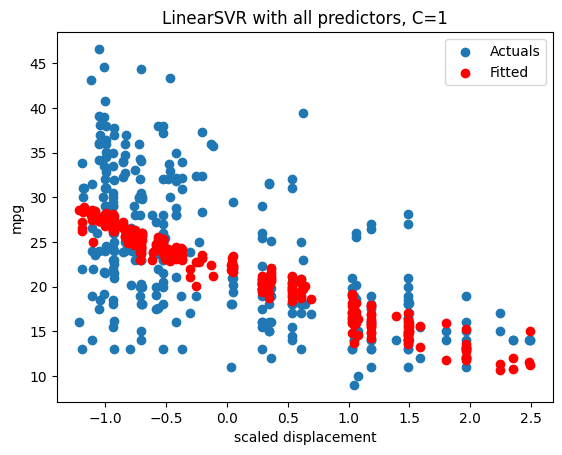

In [43]:
model = LinearSVR(C=1.0, epsilon=0.2)
model.fit(X_train, y_train)
R_2 = model.score(X_test, y_test)

# print the score rounded to two digits
print("R^2 Value: ", np.round(R_2,2))

y_fitted = model.predict(X_train)
plt.scatter(x_train, y_train, label="Actuals")
plt.scatter(x_train, y_fitted, label="Fitted", c="r")
plt.xlabel("scaled displacement")
plt.ylabel("mpg")
plt.legend()
plt.title("LinearSVR with all predictors, C=1")
plt.show()

In [44]:
pd.DataFrame({"feature": model.feature_names_in_,
             "coefficients":model.coef_})

,feature,coefficients
0,displacement,-2.024878
1,horsepower,-0.551462
2,weight,-2.430801


## SVR Summary

So you can use SVR as a more flexible regression option with a regularization penalty (like we have with Lasso/Ridge/ElasticNet) with the same caveats around the bias-variance tradeoff. Another benefit of this model is that it can handle non-linearity and is robust to outliers. There *are* computational issues with large datasets but in the kind of excel-friendly datasets that we see in FP&A this wouldn't be that big of a problem. 

So you might get a good predictive model from this where you want flexibility and the way to cover non-linear relationships. However, we lose a lot in terms of interpretability with this kind of model compared to Lasso and Ridge, and we no longer get the feature selection ability that we had before. 

## Reference

1. [`sklearn` SVM-Regression documentation](https://scikit-learn.org/stable/modules/svm.html#svm-regression)
2. Support Vector Regression Tutorial [(Analytics Vidya)](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/)
3. [Support Vector Regression (SVR) using linear and non-linear kernels](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)